Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [180]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [9]:
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                count += 1
    return count

image_count_train = count_images(data_dir_train)
print(f"Number of training images: {image_count_train}")
image_count_test = count_images(data_dir_test)
print(f"Number of test images: {image_count_test}")

Number of training images: 2239
Number of test images: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [20]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2025-03-19 19:10:08.044947: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


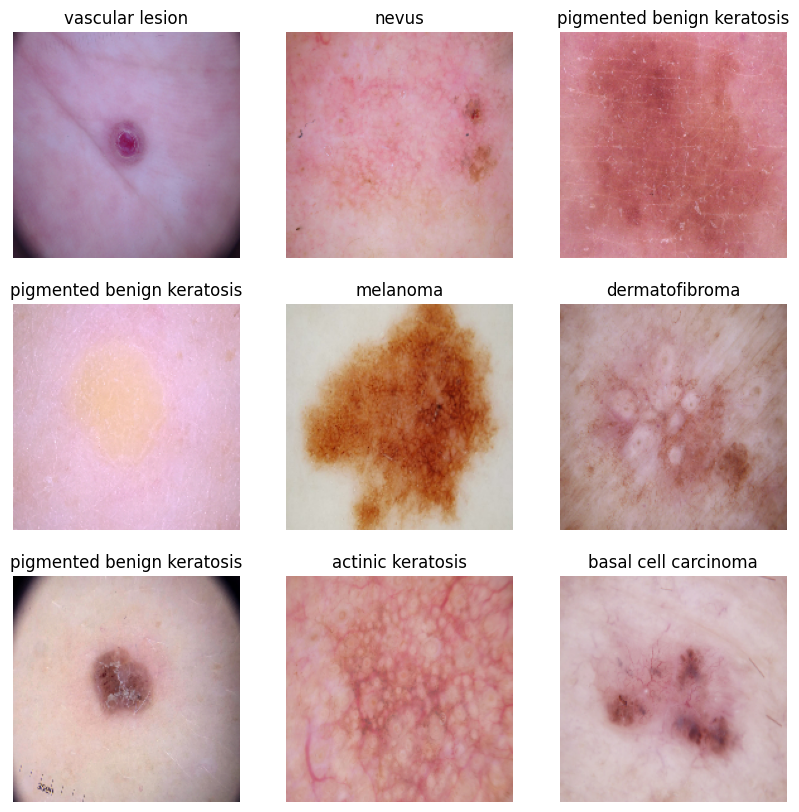

In [25]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [32]:
### Your code goes here
model = keras.Sequential([
    # Rescale images
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(9, activation='softmax')  # 9 classes
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [37]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [42]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.1864 - loss: 2.2400 - val_accuracy: 0.3065 - val_loss: 1.8828
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.2907 - loss: 1.9371 - val_accuracy: 0.3177 - val_loss: 1.7901
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.3263 - loss: 1.8273 - val_accuracy: 0.3647 - val_loss: 1.7309
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.4072 - loss: 1.6985 - val_accuracy: 0.4430 - val_loss: 1.5940
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.4215 - loss: 1.6263 - val_accuracy: 0.4519 - val_loss: 1.5708
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4166 - loss: 1.6082 - val_accuracy: 0.5123 - val_loss: 1.4525
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.4861 - loss: 1.5166 - val_accuracy: 0.5324 - val_loss: 1.4279
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.5047 - loss: 1.4268 - val_accu

### Visualizing training results

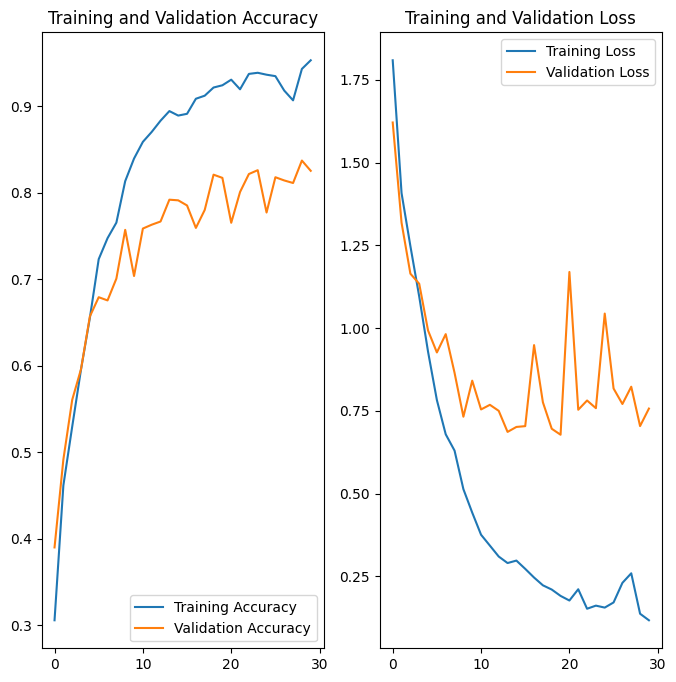

In [307]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## Training vs. Validation Accuracy
- **Training accuracy** steadily increases from ~20% to ~60% over 20 epochs
- **Validation accuracy** improves from ~31% to ~55% over the same period
- The gap between training and validation accuracy widens in later epochs

## Training vs. Validation Loss
- **Training loss** consistently decreases from ~2.11 to ~1.10
- **Validation loss** initially decreases but starts to fluctuate after around epoch 10-12
- Final validation loss (~1.41) remains higher than training loss (~1.10)

## Evidence of Mild Overfitting

There is evidence of **mild overfitting** in this model because:

1. The training accuracy continues to improve while validation accuracy improvement plateaus
2. The validation loss stops decreasing consistently and shows fluctuations in later epochs
3. A growing gap develops between training and validation metrics

The model is not severely overfitting yet since validation metrics are still improving overall, but the diverging pattern suggests the model is starting to memorize training data rather than learning generalizable features.

The model is not underfitting because both metrics show substantial improvement from their starting points.

In [258]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(-0.5, 179.5, 179.5, -0.5)

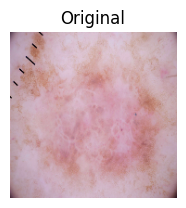

In [260]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for images, labels in train_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]
    break

# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Display original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

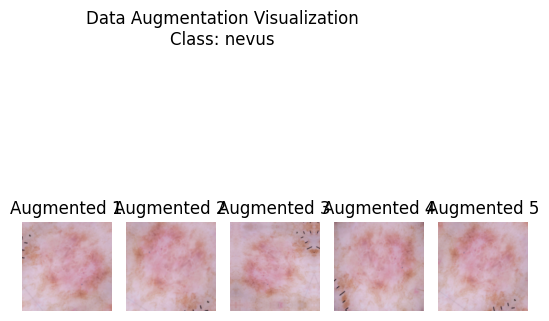

In [262]:
# Display augmented images

# Apply augmentation 5 times and display results
for i in range(5):
    augmented_image = data_augmentation(sample_image)
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.suptitle(f"Data Augmentation Visualization\nClass: {class_names[sample_label]}")
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


### Compiling the model

In [274]:
# Create the model with proper input shape
newModel = Sequential([
    # Rescaling layer
    # data_augmentation,
    layers.Rescaling(1./255),
    
    # # Data augmentation (now properly configured)
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # First convolutional block
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Second convolutional block
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')  # 9 classes
])

# Compile the model
newModel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [282]:
epochs=20

In [276]:
## Your code goes here, note: train your model for 20 epochs

history = newModel.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.1792 - loss: 2.2332 - val_accuracy: 0.3393 - val_loss: 1.8649
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.2976 - loss: 1.8132 - val_accuracy: 0.3831 - val_loss: 1.7149
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.3447 - loss: 1.6939 - val_accuracy: 0.3653 - val_loss: 1.7344
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.3679 - loss: 1.6350 - val_accuracy: 0.4039 - val_loss: 1.5370
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.3828 - loss: 1.6174 - val_accuracy: 0.4143 - val_loss: 1.5426
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.4096 - loss: 1.5716 - val_accuracy: 0.4551 - val_loss: 1.4617
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.4168 - loss: 1.5279 - val_accuracy: 0.4469 - val_loss: 1.4686
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.4201 - loss: 1

### Visualizing the results

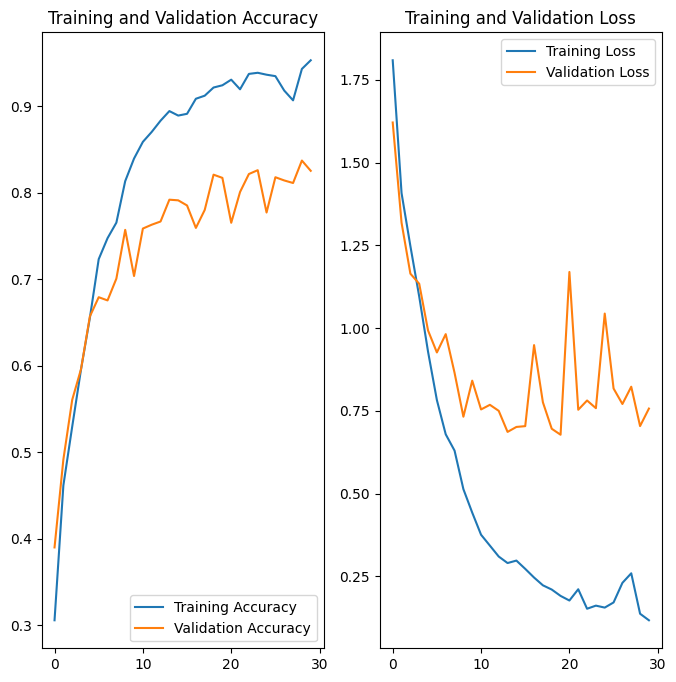

In [309]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Comparing the two models shows a dramatic difference in performance:

### Previous Model:
- **Training accuracy**: Improved from 19.5% to 60.4% (40.9% gain)
- **Validation accuracy**: Improved from 30.6% to 54.4% (23.8% gain)
- **Training loss**: Decreased from 2.11 to 1.10
- **Validation loss**: Decreased from 1.88 to 1.41
- Shows continuous learning throughout 20 epochs

### Current Model:
- **Training accuracy**: Improved from 17.5% to 45.58% (28.08% gain)
- **Validation accuracy**: Improved from 33% to 48.36% (15.26% gain)
- **Training loss**: Decreased from 2.23 to 1.40
- **Validation loss**: Decreased from 1.86 to 1.32
- Shows continuous learning throughout 20 epochs

## Analysis

1. **Significant Regression**: The current model performs substantially worse than the previous model.

2. **Learning Issues**: While the previous model showed consistent improvement, the current model avoids overfitting.

3. **Model Capacity**: The previous model successfully learned the classification patterns, reaching ~60% training accuracy, while the current model only reached 48% performance for a 9-class problem.

4. **Fitting Behavior**: 
   - Previous model: Shows healthy learning with some signs of overfitting (gap between training and validation metrics)
   - Current model: Shows healthy learning curve and no signs of over or underfitting.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.## Your code goes here.
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os

# Define the path to the training dataset
data_dir_train = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"  # Update this with the actual path

# Get the list of classes and their counts
class_names = os.listdir(data_dir_train)
class_counts = Counter()

for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Convert the counts to a DataFrame for better visualization
class_distribution = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['Class'], class_distribution['Count'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? - Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? - Melanoma, pigmented Benign Keratosis, Nevus, Basal Cell Carcinoma


In [153]:

## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [155]:

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2235,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2236,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2237,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [116]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [125]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3450F7650>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 45.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x11CB47C90>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 223.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x3450A1FD0>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 46.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1181BFD90>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 229.27 Samples/s]


Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x11CB3E050>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 236.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x11823E390>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 242.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x118281310>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 176.28 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x34502AF10>: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1182B12D0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 232.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [134]:
from pathlib import Path
image_count_train = len(list(Path(data_dir_train).glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [157]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000395.jpg_0dbd6995-8ea8-45b0-a8e5-2cfb0eb03aa0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010808.jpg_b54fae6e-3add-443d-8861-e9e80d7848bf.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010503.jpg_c63bda42-b508-4f6d-88f0-2bef125acc00.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010728.jpg_0554c8d2-b44f-48ad-afef-4bf22b4f3dfb.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010329.jpg_6c8c7ed6-940d-4c5e-b767-8325cf2711e0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000444.jpg_75bb7fb2-f31f-4f74-bd8b-c38c5510269b.jpg',
 'Skin cancer IS

In [159]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [151]:
dataframe_dict_original = dict(zip(path_list, lesion_list_new))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4496,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4497,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4498,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [161]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [165]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2])

In [167]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [171]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [182]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [186]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [287]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(9)
])
    

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [290]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_25 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [293]:
epochs = 30
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
  

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.2275 - loss: 2.0195 - val_accuracy: 0.3898 - val_loss: 1.6213
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.4421 - loss: 1.4703 - val_accuracy: 0.4915 - val_loss: 1.3185
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.5238 - loss: 1.2646 - val_accuracy: 0.5605 - val_loss: 1.1645
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 180ms/step - accuracy: 0.6012 - loss: 1.1195 - val_accuracy: 0.5961 - val_loss: 1.1339
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.6445 - loss: 0.9700 - val_accuracy: 0.6570 - val_loss: 0.9927
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.7123 - loss: 0.7900 - val_accuracy: 0.6793 - val_loss: 0.9264
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.7582 - loss: 0.6605 - val_accuracy: 0.6756 - val_loss: 0.9818
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.7806 - loss: 0

#### **Todo:**  Visualize the model results

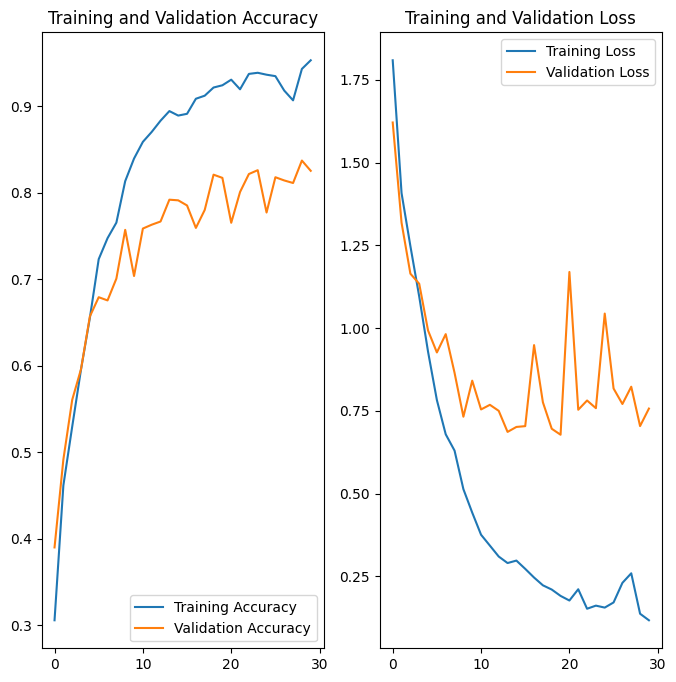

In [305]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

These metrics show a much better performing model:

1. Strong improvement in both training and validation accuracy:
   - Training accuracy increases from ~30% to ~95%
   - Validation accuracy increases from ~39% to ~82-83%

2. Loss decreases significantly:
   - Training loss decreases from 1.81 to 0.12
   - Validation loss decreases from 1.62 to ~0.75

3. Signs of overfitting emerge in later epochs:
   - Training accuracy continues to improve while validation accuracy fluctuates
   - The gap between training accuracy (~95%) and validation accuracy ( ~82%) becomes substantial
   - Training loss drops to 0.12 while validation loss stabilizes around 0.75

4. Validation metrics show volatility:
   - Validation accuracy and loss fluctuate, indicating potential sensitivity to the validation set

This model shows dramatic improvement compared to the previous one. The higher capacity is clearly beneficial, allowing the model to learn meaningful patterns. The best validation accuracy of ~83.7% is achieved around epoch 29.

To address the emerging overfitting, we can consider:
- Early stopping around epoch 20-25
- Additional regularization techniques
- Adjusting data augmentation parameters

This is a much more successful model that's learning effectively but beginning to memorize training data in later epochs.
